In [1]:
DATA_PATH = 'F:/ROHAN4600マルチモーダルデータベース/ROHAN4600_zundamon_voice/ROHAN4600_0001.wav'
OUTPUT_PATH = 'F:/ROHAN4600マルチモーダルデータベース/wav_outs/003.wav'

AttributeError: module 'matplotlib' has no attribute 'axes'

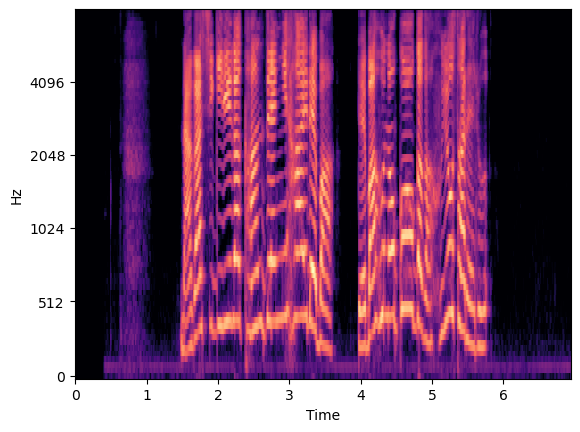

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [2]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

sr = 16000
n_fft = 800
hop_length = 200
win_length = 800
n_mels = 80

waveform, _ = librosa.load(DATA_PATH, sr=sr)

# メルスペクトログラムの計算
mel_spectrogram = librosa.feature.melspectrogram(
    y=waveform,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

# 対数変換
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# 正規化
min_value = -80
max_value = 0
normalized_mel_spectrogram = (mel_spectrogram - min_value) / (max_value - min_value)

# メルスペクトログラムの表示
librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [ ]:
print(normalized_mel_spectrogram.T.shape)

In [ ]:
min_value = mel_spectrogram.min()
max_value = mel_spectrogram.max()
print(min_value)
print(max_value)

In [3]:
print(mel_spectrogram.T)

[[-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 ...
 [-71.82849  -52.778954 -51.10508  ... -80.       -80.       -80.      ]
 [-76.9104   -53.555138 -51.864677 ... -80.       -80.       -80.      ]
 [-66.2963   -55.21733  -53.68268  ... -80.       -80.       -80.      ]]


In [4]:
print(normalized_mel_spectrogram.T)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.10214386 0.34026307 0.3611865  ... 0.         0.         0.        ]
 [0.03862    0.33056077 0.35169154 ... 0.         0.         0.        ]
 [0.17129621 0.30978337 0.32896653 ... 0.         0.         0.        ]]


In [5]:
normalized_mel_spectrogram = normalized_mel_spectrogram.T
restored_mel_spectrogram = normalized_mel_spectrogram * (max_value - min_value) + min_value

In [6]:
print(restored_mel_spectrogram)

[[-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 ...
 [-71.82849  -52.778954 -51.10508  ... -80.       -80.       -80.      ]
 [-76.9104   -53.555138 -51.864677 ... -80.       -80.       -80.      ]
 [-66.2963   -55.21733  -53.68268  ... -80.       -80.       -80.      ]]


In [7]:
power_spec = librosa.db_to_power(restored_mel_spectrogram.T)#, ref=np.max)

inverse_mel_spectrogram = librosa.feature.inverse.mel_to_stft(
    M=power_spec,
    sr=sr,
    n_fft=n_fft
)

reconstructed_waveform = librosa.griffinlim(
    inverse_mel_spectrogram,
    n_iter=100,
    hop_length=hop_length,
    win_length=win_length
)


In [8]:
WAV_DIR = "F:/ROHAN4600マルチモーダルデータベース/wav_outs/"

import soundfile as sf

# 音声波形を保存するパスとサンプリングレートを指定します
output_path = WAV_DIR + '050.wav'
sr = 16000  # 例として44100Hzのサンプリングレートを使用します

# 音声波形を保存します
sf.write(output_path, reconstructed_waveform, sr)

In [33]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def logmelspectrogram(
    y,
    sr,
    n_fft=None,
    hop_length=None,
    win_length=None,
    n_mels=80,
    fmin=None,
    fmax=None,
    clip=0.001,
):
    """Compute log-melspectrogram.
    Args:
        y (ndarray): Waveform.
        sr (int): Sampling rate.
        n_fft (int, optional): FFT size.
        hop_length (int, optional): Hop length. Defaults to 12.5ms.
        win_length (int, optional): Window length. Defaults to 50 ms.
        n_mels (int, optional): Number of mel bins. Defaults to 80.
        fmin (int, optional): Minimum frequency. Defaults to 0.
        fmax (int, optional): Maximum frequency. Defaults to sr / 2.
        clip (float, optional): Clip the magnitude. Defaults to 0.001.
    Returns:
        numpy.ndarray: Log-melspectrogram.
    """
    if hop_length is None:
        hop_length = int(sr * 0.0125)
    if win_length is None:
        win_length = int(sr * 0.050)
    if n_fft is None:
        n_fft = next_power_of_2(win_length)

    S = librosa.stft(
        y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window="hann"
    )

    fmin = 0 if fmin is None else fmin
    fmax = sr // 2 if fmax is None else fmax

    # メルフィルタバンク
    mel_basis = librosa.filters.mel(
        sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels
    )
    # スペクトログラム -> メルスペクトログラム
    S = np.dot(mel_basis, np.abs(S))

    # クリッピング
    S = np.maximum(S, clip)

    # 対数を取る
    S = np.log10(S)

    # Time first: (T, N)
    return S.T


def logmelspectrogram_to_audio(
    logmel,
    sr,
    n_fft=None,
    hop_length=None,
    win_length=None,
    fmin=None,
    fmax=None,
    n_iter=4,
):
    """Log-melspectrogram to audio.
    Args:
        logmel (ndarray): Log-melspectrogram.
        sr (int): Sampling rate.
        n_fft (int, optional): FFT size.
        hop_length (int, optional): Hop length. Defaults to 12.5ms.
        win_length (int, optional): Window length. Defaults to 50 ms.
        fmin (int, optional): Minimum frequency. Defaults to 0.
        fmax (int, optional): Maximum frequency. Defaults to sr / 2.
        n_iter (int, optional): Number of power iterations. Defaults to 4.
    Returns:
        numpy.ndarray: Waveform.
    """
    if hop_length is None:
        hop_length = int(sr * 0.0125)
    if win_length is None:
        win_length = int(sr * 0.050)
    if n_fft is None:
        n_fft = next_power_of_2(win_length)

    fmin = 0 if fmin is None else fmin
    fmax = sr // 2 if fmax is None else fmax

    mel = np.exp(logmel * np.log(10)).T
    S = librosa.feature.inverse.mel_to_stft(
        mel,
        n_fft=n_fft,
        power=1.0,
        sr=sr,
        fmin=fmin,
        fmax=fmax,
    )
    y = librosa.griffinlim(
        S, hop_length=hop_length, win_length=win_length, window="hann", n_iter=n_iter
    )

    return y


In [37]:
# メルスペクトログラムの計算
from scipy.io import wavfile
sr=16000
_sr, x = wavfile.read(DATA_PATH)
if x.dtype in [np.int16, np.int32]:
    x = (x / np.iinfo(x.dtype).max).astype(np.float64)
x = librosa.resample(x, orig_sr=_sr, target_sr=sr)
out_feats = logmelspectrogram(x, sr)


In [38]:
print(out_feats)

[[-3.         -3.         -3.         ... -3.         -3.
  -3.        ]
 [-3.         -3.         -3.         ... -3.         -3.
  -3.        ]
 [-3.         -3.         -3.         ... -3.         -3.
  -3.        ]
 ...
 [-3.         -2.35029013 -2.1963295  ... -3.         -3.
  -3.        ]
 [-3.         -2.38953577 -2.22335386 ... -3.         -3.
  -3.        ]
 [-2.94455437 -2.41014913 -2.28616215 ... -3.         -3.
  -3.        ]]


In [39]:
#fig, ax = plt.subplots(len(out_feats), 1, figsize=(8,10), sharex=True, sharey=True)
import librosa.display
import matplotlib.pyplot as plt

sr = 16000
hop_length = int(sr * 0.0125)
mesh = librosa.display.specshow(out_feats.T, sr=sr, x_axis="time", y_axis="frames", hop_length=hop_length)
plt.tight_layout()

In [40]:
# Denormalization
logmel = scaler.inverse_transform(out_feats)

gen_wav = logmelspectrogram_to_audio(logmel, sample_rate)

NameError: name 'scaler' is not defined